In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects

import requests,pickle,math
from io import StringIO as sio
from io import BytesIO as bio

import baltic as bt
import numpy as np

import bezier ## requires bezier module

####
# This notebook recapitulates the original by dr. Sidney Bell: https://github.com/blab/siv-cst/blob/master/figures/main-text/F3-cst.ipynb
# It represents one of the figures in her PLOS Pathogens paper: https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006466
####

address='https://raw.githubusercontent.com/blab/siv-cst/master/data/hosts/host_mtdna.nexus' ## where the tree we'll use lives

fetch_tree = requests.get(address) ## fetch tree
treeFile=sio(fetch_tree.text) ## stream from repo copy

ll=bt.loadNexus(treeFile,absoluteTime=False) ## treeFile here can alternatively be a path to a local file


rates_url='https://raw.githubusercontent.com/blab/siv-cst/master/beast/main/full_dataset/discreteTraits/results/discreteTraits_2016-10-25_actualRates.csv'

fetch_rates = requests.get(rates_url) ## fetch rate matrix
rates={}
for line in sio(fetch_rates.text):
    l=line.strip('\n').split(',')
    if l[0]=='':
        hosts=l[1:]
        rates={h1: {h2: None for h2 in hosts} for h1 in hosts}
    else:
        for i,h in enumerate(hosts):
            if l[i+1]!='':
                rates[l[0]][h]=float(l[i+1])


bf_url='https://raw.githubusercontent.com/blab/siv-cst/master/beast/main/full_dataset/discreteTraits/results/discreteTraits_2016-10-25_bf.csv'

fetch_bfs = requests.get(bf_url) ## fetch Bayes factors
bfs={}
for line in sio(fetch_bfs.text):
#     print(line)
    l=line.strip('\n').split(',')
    if l[0]=='':
        hosts=l[1:]
        bfs={h1: {h2: None for h2 in hosts} for h1 in hosts}
    else:
        for i,h in enumerate(hosts):
            if l[i+1]!='':
                bfs[l[0]][h]=float(l[i+1])


host_url='https://raw.githubusercontent.com/blab/siv-cst/master/data/hosts/common_names.p'

fetch_hosts = requests.get(host_url)
common_names = pickle.load(bio(fetch_hosts.content)) ## load Sidney's colours


def Bezier_control(pointA,pointB,height,frac):
    """ 
    Given a line defined by 2 points A & B, 
    find a third point at a given distance (height) that defines a line perpendicular to line AB which intercepts AB at fraction (frac) along AB.
    Equation derived by Luiz Max Fagundes de Carvalho (University of Edinburgh).
    """
    x1,y1=pointA
    x2,y2=pointB

    sign=1
    if x1>x2:
        sign=-1

    slope = (y2-y1) / (x2-x1)
    d=np.sqrt((y2-y1)**2 + (x2-x1)**2) ## distance between points
    
    h=np.sqrt(height**2+(d*frac)**2) ## distance between desired height and point along line

    n1=x1+h*np.cos(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign ## magic
    n2=y1+h*np.sin(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign

    return (n1,n2) ## return third point's coordinate


colours={'Gorilla_gorilla': (0.47058823529411764, 0.10980392156862745, 0.5254901960784314, 1.0), 'Gorilla': (0.47058823529411764, 0.10980392156862745, 0.5254901960784314, 1.0), 'GOR': (0.47058823529411764, 0.10980392156862745, 0.5254901960784314, 1.0), 'Homo_sapiens': (0.32941176470588235, 0.11764705882352941, 0.6509803921568628, 1.0), 'Human': (0.32941176470588235, 0.11764705882352941, 0.6509803921568628, 1.0), 'HIV': (0.32941176470588235, 0.11764705882352941, 0.6509803921568628, 1.0), 'Pan_troglodytes_troglodytes': (0.2627450980392157, 0.2, 0.7450980392156863, 1.0), 'Chimp_ptt': (0.2627450980392157, 0.2, 0.7450980392156863, 1.0), 'Pan_troglodytes_schweinfurthii': (0.2627450980392157, 0.2, 0.7450980392156863, 1.0), 'Chimp_pts': (0.2627450980392157, 0.2, 0.7450980392156863, 1.0), 'P._t._schweinfurthii': (0.2627450980392157, 0.2, 0.7450980392156863, 1.0), 'CPZ': (0.2627450980392157, 0.2, 0.7450980392156863, 1.0), 'Colobus_guereza': (0.24705882352941178, 0.3176470588235294, 0.8, 1.0), 'Colobus_Monkey': (0.24705882352941178, 0.3176470588235294, 0.8, 1.0), 'COL': (0.24705882352941178, 0.3176470588235294, 0.8, 1.0), 'Piliocolobus_badius': (0.2549019607843137, 0.43137254901960786, 0.807843137254902, 1.0), 'Western_red_colobus': (0.2549019607843137, 0.43137254901960786, 0.807843137254902, 1.0), 'WRC': (0.2549019607843137, 0.43137254901960786, 0.807843137254902, 1.0), 'OLC': (0.2549019607843137, 0.43137254901960786, 0.807843137254902, 1.0), 'Cercocebus_atys': (0.2823529411764706, 0.5294117647058824, 0.7764705882352941, 1.0), 'Sooty_Mangabey': (0.2823529411764706, 0.5294117647058824, 0.7764705882352941, 1.0), 'SMM': (0.2823529411764706, 0.5294117647058824, 0.7764705882352941, 1.0), 'Cercocebus_torquatus': (0.3254901960784314, 0.6078431372549019, 0.7098039215686275, 1.0), 'Red-capped_Mangabey': (0.3254901960784314, 0.6078431372549019, 0.7098039215686275, 1.0), 'RCM': (0.3254901960784314, 0.6078431372549019, 0.7098039215686275, 1.0), 'Mandrillus_sphinx': (0.3764705882352941, 0.6666666666666666, 0.6235294117647059, 1.0), 'Mandrill': (0.3764705882352941, 0.6666666666666666, 0.6235294117647059, 1.0), 'DRL': (0.3764705882352941, 0.6666666666666666, 0.6235294117647059, 1.0), 'MND': (0.3764705882352941, 0.6666666666666666, 0.6235294117647059, 1.0), 'Papio_cynocephalus': (0.4392156862745098, 0.7058823529411765, 0.5294117647058824, 1.0), 'Baboon': (0.4392156862745098, 0.7058823529411765, 0.5294117647058824, 1.0), 'Miopithecus_ogouensis': (0.5137254901960784, 0.7294117647058823, 0.4392156862745098, 1.0), 'Talapoin_Monkey': (0.5137254901960784, 0.7294117647058823, 0.4392156862745098, 1.0), 'TAL': (0.5137254901960784, 0.7294117647058823, 0.4392156862745098, 1.0), 'Cercopithecus_aethiops_pygerythrus': (0.596078431372549, 0.7411764705882353, 0.3686274509803922, 1.0), 'Vervet': (0.596078431372549, 0.7411764705882353, 0.3686274509803922, 1.0), 'VER': (0.596078431372549, 0.7411764705882353, 0.3686274509803922, 1.0), 'Cercopithecus_aethiops_aethiops': (0.596078431372549, 0.7411764705882353, 0.3686274509803922, 1.0), 'Grivet': (0.596078431372549, 0.7411764705882353, 0.3686274509803922, 1.0), 'GRV': (0.596078431372549, 0.7411764705882353, 0.3686274509803922, 1.0), 'Cercopithecus_aethiops_tantalus': (0.596078431372549, 0.7411764705882353, 0.3686274509803922, 1.0), 'Tantalus_Monkey': (0.596078431372549, 0.7411764705882353, 0.3686274509803922, 1.0), 'TAN': (0.596078431372549, 0.7411764705882353, 0.3686274509803922, 1.0), 'Cercopithecus_aethiops_sabaeus': (0.596078431372549, 0.7411764705882353, 0.3686274509803922, 1.0), 'Sabaeus_Monkey': (0.596078431372549, 0.7411764705882353, 0.3686274509803922, 1.0), 'SAB': (0.596078431372549, 0.7411764705882353, 0.3686274509803922, 1.0), 'Cercopithecus_solatus': (0.6823529411764706, 0.7411764705882353, 0.3137254901960784, 1.0), 'Sun-tailed_Monkey': (0.6823529411764706, 0.7411764705882353, 0.3137254901960784, 1.0), 'SOL': (0.6823529411764706, 0.7411764705882353, 0.3137254901960784, 1.0), 'SUN': (0.6823529411764706, 0.7411764705882353, 0.3137254901960784, 1.0), 'Cercopithecus_lhoesti': (0.7647058823529411, 0.7294117647058823, 0.27450980392156865, 1.0), 'LHoests_Monkey': (0.7647058823529411, 0.7294117647058823, 0.27450980392156865, 1.0), 'LST': (0.7647058823529411, 0.7294117647058823, 0.27450980392156865, 1.0), 'Cercopithecus_erythrotis': (0.8313725490196079, 0.6941176470588235, 0.24705882352941178, 1.0), 'Red-eared_Guenon': (0.8313725490196079, 0.6941176470588235, 0.24705882352941178, 1.0), 'PRG': (0.8313725490196079, 0.6941176470588235, 0.24705882352941178, 1.0), 'REG': (0.8313725490196079, 0.6941176470588235, 0.24705882352941178, 1.0), 'Cercopithecus_ascanius': (0.8784313725490196, 0.6313725490196078, 0.22745098039215686, 1.0), 'Red-tailed_Guenon': (0.8784313725490196, 0.6313725490196078, 0.22745098039215686, 1.0), 'ASC': (0.8784313725490196, 0.6313725490196078, 0.22745098039215686, 1.0), 'Cercopithecus_cephus': (0.9019607843137255, 0.5411764705882353, 0.20784313725490197, 1.0), 'Mustached_Monkey': (0.9019607843137255, 0.5411764705882353, 0.20784313725490197, 1.0), 'MUS': (0.9019607843137255, 0.5411764705882353, 0.20784313725490197, 1.0), 'Cercopithecus_nictitans': (0.8980392156862745, 0.4196078431372549, 0.1843137254901961, 1.0), 'Greater_Spot-nosed_Monkey': (0.8980392156862745, 0.4196078431372549, 0.1843137254901961, 1.0), 'GSN': (0.8980392156862745, 0.4196078431372549, 0.1843137254901961, 1.0), 'Cercopithecus_albogularis': (0.8745098039215686, 0.27450980392156865, 0.1568627450980392, 1.0), 'Sykes_Monkey': (0.8745098039215686, 0.27450980392156865, 0.1568627450980392, 1.0), 'SYK': (0.8745098039215686, 0.27450980392156865, 0.1568627450980392, 1.0), 'Cercopithecus_mona': (0.8588235294117647, 0.12941176470588237, 0.13333333333333333, 1.0), 'Mona_Monkey': (0.8588235294117647, 0.12941176470588237, 0.13333333333333333, 1.0), 'MON': (0.8588235294117647, 0.12941176470588237, 0.13333333333333333, 1.0), 'DEN': (0.8588235294117647, 0.12941176470588237, 0.13333333333333333, 1.0), 'Cercopithecus_neglectus': (0.8588235294117647, 0.12941176470588237, 0.13333333333333333, 1.0), 'DeBrazzas_Monkey': (0.8588235294117647, 0.12941176470588237, 0.13333333333333333, 1.0), 'DEB': (0.8588235294117647, 0.12941176470588237, 0.13333333333333333, 1.0)}

Gorilla Human 265999973.54 5.86946446444
Tantalus_Monkey Grivet 1433.14808675 2.98440867017
Tantalus_Monkey Vervet 1303.39335003 3.35913040774
Sooty_Mangabey Human 265999973.54 8.91806852284
Mona_Monkey DeBrazzas_Monkey 119619.559228 1.50101369726
Mona_Monkey Sykes_Monkey 2892.88015205 1.41579803771
Mona_Monkey Talapoin_Monkey 480.602422707 1.4684670751
Mona_Monkey Mustached_Monkey 2037.17709138 1.88240257284
Red-capped_Mangabey Sooty_Mangabey 307.757121618 1.06804895326
Red-capped_Mangabey Mona_Monkey 242.388492034 1.49331292877
Red-capped_Mangabey Chimp_pts 228.080607221 0.811188709914
Red-capped_Mangabey Mandrill 339.454542127 2.01016078956
Chimp_pts Chimp_ptt 1113.39511431 1.71038755252
Vervet Baboon 265999973.54 1.64191256706
Mandrill Western_red_colobus 23911.2455939 1.47070537156
Chimp_ptt Human 265999973.54 3.64977428925
Chimp_ptt Gorilla 59809.9367792 1.91250568185
Mustached_Monkey Red-tailed_Guenon 461.970531197 1.20307058468
Mustached_Monkey Greater_Spot-nosed_Monkey 9180.77

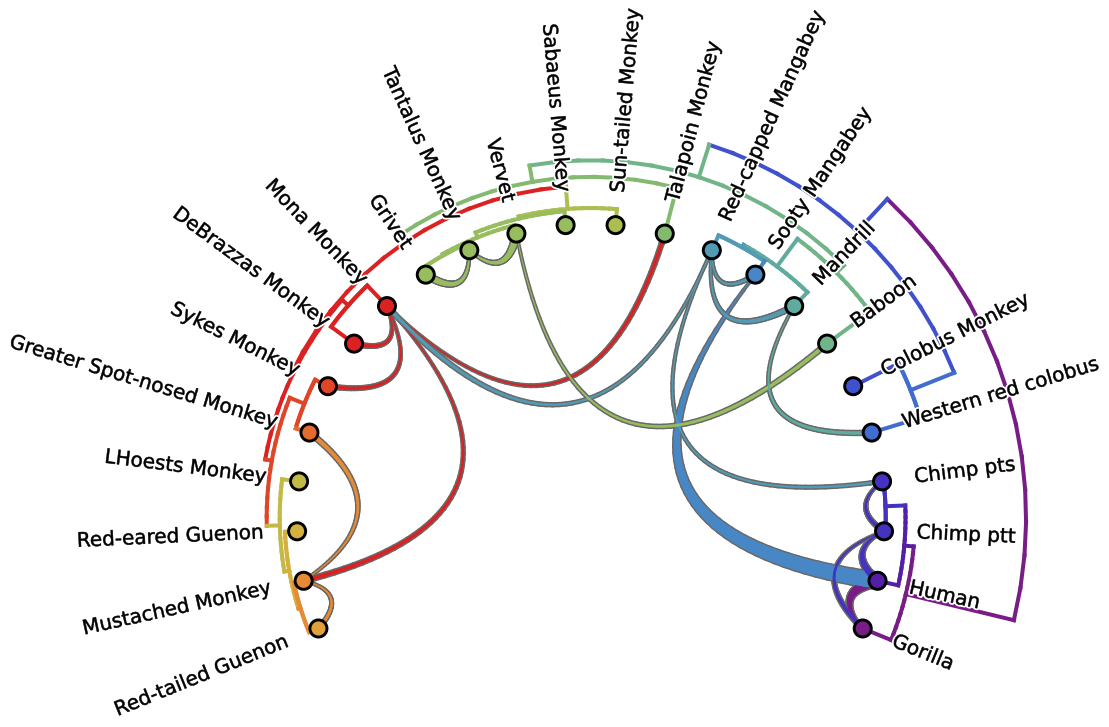

In [2]:
fig = plt.subplots(figsize=(15,15),facecolor='w')

gs = gridspec.GridSpec(1,1,hspace=0.01,wspace=0.01)
ax=plt.subplot(gs[0])

## parameters of the circle along with the tree will be plotted
inwSpace=-0.8
circFrac=0.65
circStart=(1-circFrac)/2

ll.plotCircularTree(ax,inwardSpace=inwSpace,colour=lambda k: colours[k.traits['host']],circStart=circStart,circFrac=circFrac,width=4) ## plot circular tree
ll.plotCircularPoints(ax,colour=lambda k: colours[k.traits['host']],size=200,inwardSpace=inwSpace,circStart=circStart,circFrac=circFrac) ## plot circular points

### what's under the hood when computing circular coordinates
x_attr=lambda k:k.x
y_attr=lambda k:k.y

if inwSpace<0: inwSpace-=ll.treeHeight
circ_s=circStart*math.pi*2
circ=circFrac*math.pi*2
allXs=list(map(x_attr,ll.Objects))
normaliseHeight=lambda value: (value-min(allXs))/(max(allXs)-min(allXs))
linspace=lambda start,stop,n: list(start+((stop-start)/(n-1))*i for i in range(n)) if n>1 else stop
###

dist=lambda p1,p2: abs(p2[0]-p1[0])+abs(p2[1]-p1[1]) ## compute distance between two points

for h1 in rates: ## iterate over origin hosts in rates
    for h2 in rates: ## iterate over destination hosts in rates
        if bfs[h1][h2] and bfs[h1][h2]>120.0: ## if BF>120
            print(h1,h2,bfs[h1][h2],rates[h1][h2])
            k1=ll.getExternal(lambda w: h1==common_names[w.name])[0] ## get host 1
            k2=ll.getExternal(lambda w: h2==common_names[w.name])[0] ## get host 2
            
            x1=normaliseHeight(x_attr(k1)+inwSpace) ## find normalised x position along circle's radius
            y1=circ_s+circ*y_attr(k1)/ll.ySpan ## get y position along circle's perimeter
            X1=math.sin(y1)*x1 ## transform
            Y1=math.cos(y1)*x1 ## transform
            
            x2=normaliseHeight(x_attr(k2)+inwSpace) ## find normalised x position along circle's radius
            y2=circ_s+circ*y_attr(k2)/ll.ySpan ## get y position along circle's perimeter
            X2=math.sin(y2)*x2 ## transform
            Y2=math.cos(y2)*x2 ## transform
            
            p1=(X1,Y1) ## circular position of host 1
            p2=(X2,Y2) ## circular position of host 2
            
            d=dist(p1,p2) ## raw distance between hosts in tree
            
            mid1=Bezier_control(p1,p2,d/1.5,0.5) ## bezier control point given host1>host2 direction
            mid2=Bezier_control(p2,p1,d/1.5,0.5) ## same but host2>host1
            
            mid=sorted([mid1,mid2],key=lambda m: dist(m,(0,0)))[0] ## pick the control point closest to the center (0,0)
            
            curve=bezier.Curve(np.array([p1,mid,p2]).transpose(),2) ## get Bezier curve from host points and control point
            
            grid=np.linspace(0.01,1,50) ## grid of points going roughly from 0 to 1
            xs,ys=curve.evaluate_multi(grid) ## get bezier coordinates
            
            for i in range(len(grid)-1): ## iterate over neighbouring segments of bezier curve
                xx=xs[i],xs[i+1]
                yy=ys[i],ys[i+1]
                f=i/(len(xs)-1)
                
                c=colours[h1]
                ax.plot(xx,yy,lw=1+f*rates[h1][h2]*1.7,alpha=1,color=c,zorder=1,solid_capstyle='round')
                ax.plot(xx,yy,lw=4+f*rates[h1][h2]*1.7,alpha=1,color='dimgrey',zorder=0,solid_capstyle='round')


                
                
for k in ll.getExternal(): ## iterate over tips
    x=normaliseHeight(x_attr(k)+inwSpace)-0.23 ## find normalised x position along circle's radius, positioned a bit outwards
    y=circ_s+circ*y_attr(k)/ll.ySpan ## get y position along circle's perimeter
    X=math.sin(y)*x ## transform
    Y=math.cos(y)*x ## transform
    
    ha='right' ## align right
    va='center'
    rot=np.rad2deg(-y)+90 ## rotate text
    
    if k.y/ll.ySpan>0.5: ## over halfway through the tree, rotate the other way, align left
        ha='left'
        rot+=180
    
    effects=[path_effects.Stroke(linewidth=4, foreground='white'), 
             path_effects.Stroke(linewidth=0.5, foreground='k')] ## black text, white outline
    
    ax.text(X,Y,common_names[k.name].replace('_',' '),size=20,rotation=rot,ha=ha,va=va,fontweight=100,zorder=20,rotation_mode='anchor',path_effects=effects) ## add text

ax.plot()

ax.set_aspect(1)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(size=0)
[ax.spines[loc].set_visible(False) for loc in ax.spines]
plt.show()